### PCA on single-trial heatmaps
This notebook is used to perform PCA on single-trial LRP heatmaps derived from the VGG-Hum and VGG-MaxP models.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import os
import re
import glob
from facesim3d import local_paths

# ==== CONFIG ====
model_type = "MaxP"    # else: HumJudge
print("Model Type:", model_type)

if model_type == "HumJudge":
    input_dir = local_paths.DIR_SINGLE_HJ_HEATMAPS
    output_dir = local_paths.DIR_PCA_AE_RESULTS_HJ
    exclude_file = "overall_average_odd_one_out_VGGFaceHumanJudgment.npy"
    work_path = local_paths.DIR_PCA_AE_RESULTS_HJ

else:
    input_dir = local_paths.DIR_SINGLE_MaxP_HEATMAPS
    output_dir = local_paths.DIR_PCA_AE_RESULTS_MaxP
    exclude_file = "overall_average_odd_one_out_VGGFace_Maxp5_3_Sim"
    work_path = local_paths.DIR_PCA_AE_RESULTS_MaxP
    
os.makedirs(output_dir, exist_ok=True)

In [ ]:
npy_files = sorted(glob.glob(os.path.join(input_dir, "*.npy")))
print(f"Found {len(npy_files)} heatmaps")

Found 161700 heatmaps


In [ ]:
from tqdm import tqdm

N = len(npy_files)
flat_dim = 224 * 224   # flatten size

mm_path = os.path.join(work_path, "heatmaps_memmap.dat")    # VGG-MaxP
X = np.memmap(mm_path, dtype="float32", mode="w+", shape=(N, flat_dim))

def normalize_lrp(arr):
    # Option A (recommended): Normalize by total relevance
    norm = np.sum(np.abs(arr))  
    if norm > 0:
        arr = arr / norm
    return arr

for i, f in enumerate(tqdm(npy_files, desc="Loading + normalizing")):
    arr = np.load(f).astype("float32")     # (224, 224)
    arr = normalize_lrp(arr)               # normalize
    X[i] = arr.reshape(-1)                 # flatten

del X

IOPub message rate exceeded.██▋       | 43142/161700 [52:18<2:09:30, 15.26it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loading + normalizing: 100%|██████████| 161700/161700 [2:57:40<00:00, 15.17it/s]  


In [ ]:
# Load again
mm_path = os.path.join(work_path, "heatmaps_memmap.dat")    # VGG-MaxP

flat_dim = 224 * 224   # flatten size
N = len(npy_files)

# Load again
X = np.memmap(mm_path, dtype="float32", mode="r", shape=(N, flat_dim))

In [5]:
print(f"Shape of X: {X.shape}")

Shape of X: (161700, 50176)


In [20]:
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm

n_components = 200
batch_size = 2000

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for start in tqdm(range(0, N, batch_size), desc="Fitting PCA"):
    ipca.partial_fit(X[start:start + batch_size])

Fitting PCA:   1%|          | 1/93 [01:58<3:02:26, 118.99s/it]


KeyboardInterrupt: 

In [6]:
X_pca = np.zeros((N, n_components), dtype="float32")

for start in tqdm(range(0, N, batch_size), desc="Transforming"):
    X_pca[start:start + batch_size] = ipca.transform(X[start:start + batch_size])

Transforming: 100%|██████████| 93/93 [01:15<00:00,  1.23it/s]


In [19]:
import numpy as np

# cumulative explained variance
cumvar = np.cumsum(ipca.explained_variance_ratio_)

for i, cv in enumerate(cumvar, start=1):
    print(f"PC {i}: cumulative variance = {cv:.3f}")

PC 1: cumulative variance = 0.072
PC 2: cumulative variance = 0.106
PC 3: cumulative variance = 0.134
PC 4: cumulative variance = 0.157
PC 5: cumulative variance = 0.179
PC 6: cumulative variance = 0.198
PC 7: cumulative variance = 0.216
PC 8: cumulative variance = 0.232
PC 9: cumulative variance = 0.247
PC 10: cumulative variance = 0.261
PC 11: cumulative variance = 0.275
PC 12: cumulative variance = 0.288
PC 13: cumulative variance = 0.300
PC 14: cumulative variance = 0.312
PC 15: cumulative variance = 0.323
PC 16: cumulative variance = 0.334
PC 17: cumulative variance = 0.344
PC 18: cumulative variance = 0.354
PC 19: cumulative variance = 0.362
PC 20: cumulative variance = 0.371


In [11]:
# reshape and de-flatten the PCs
pc_images = ipca.components_.reshape((-1, 224, 224))

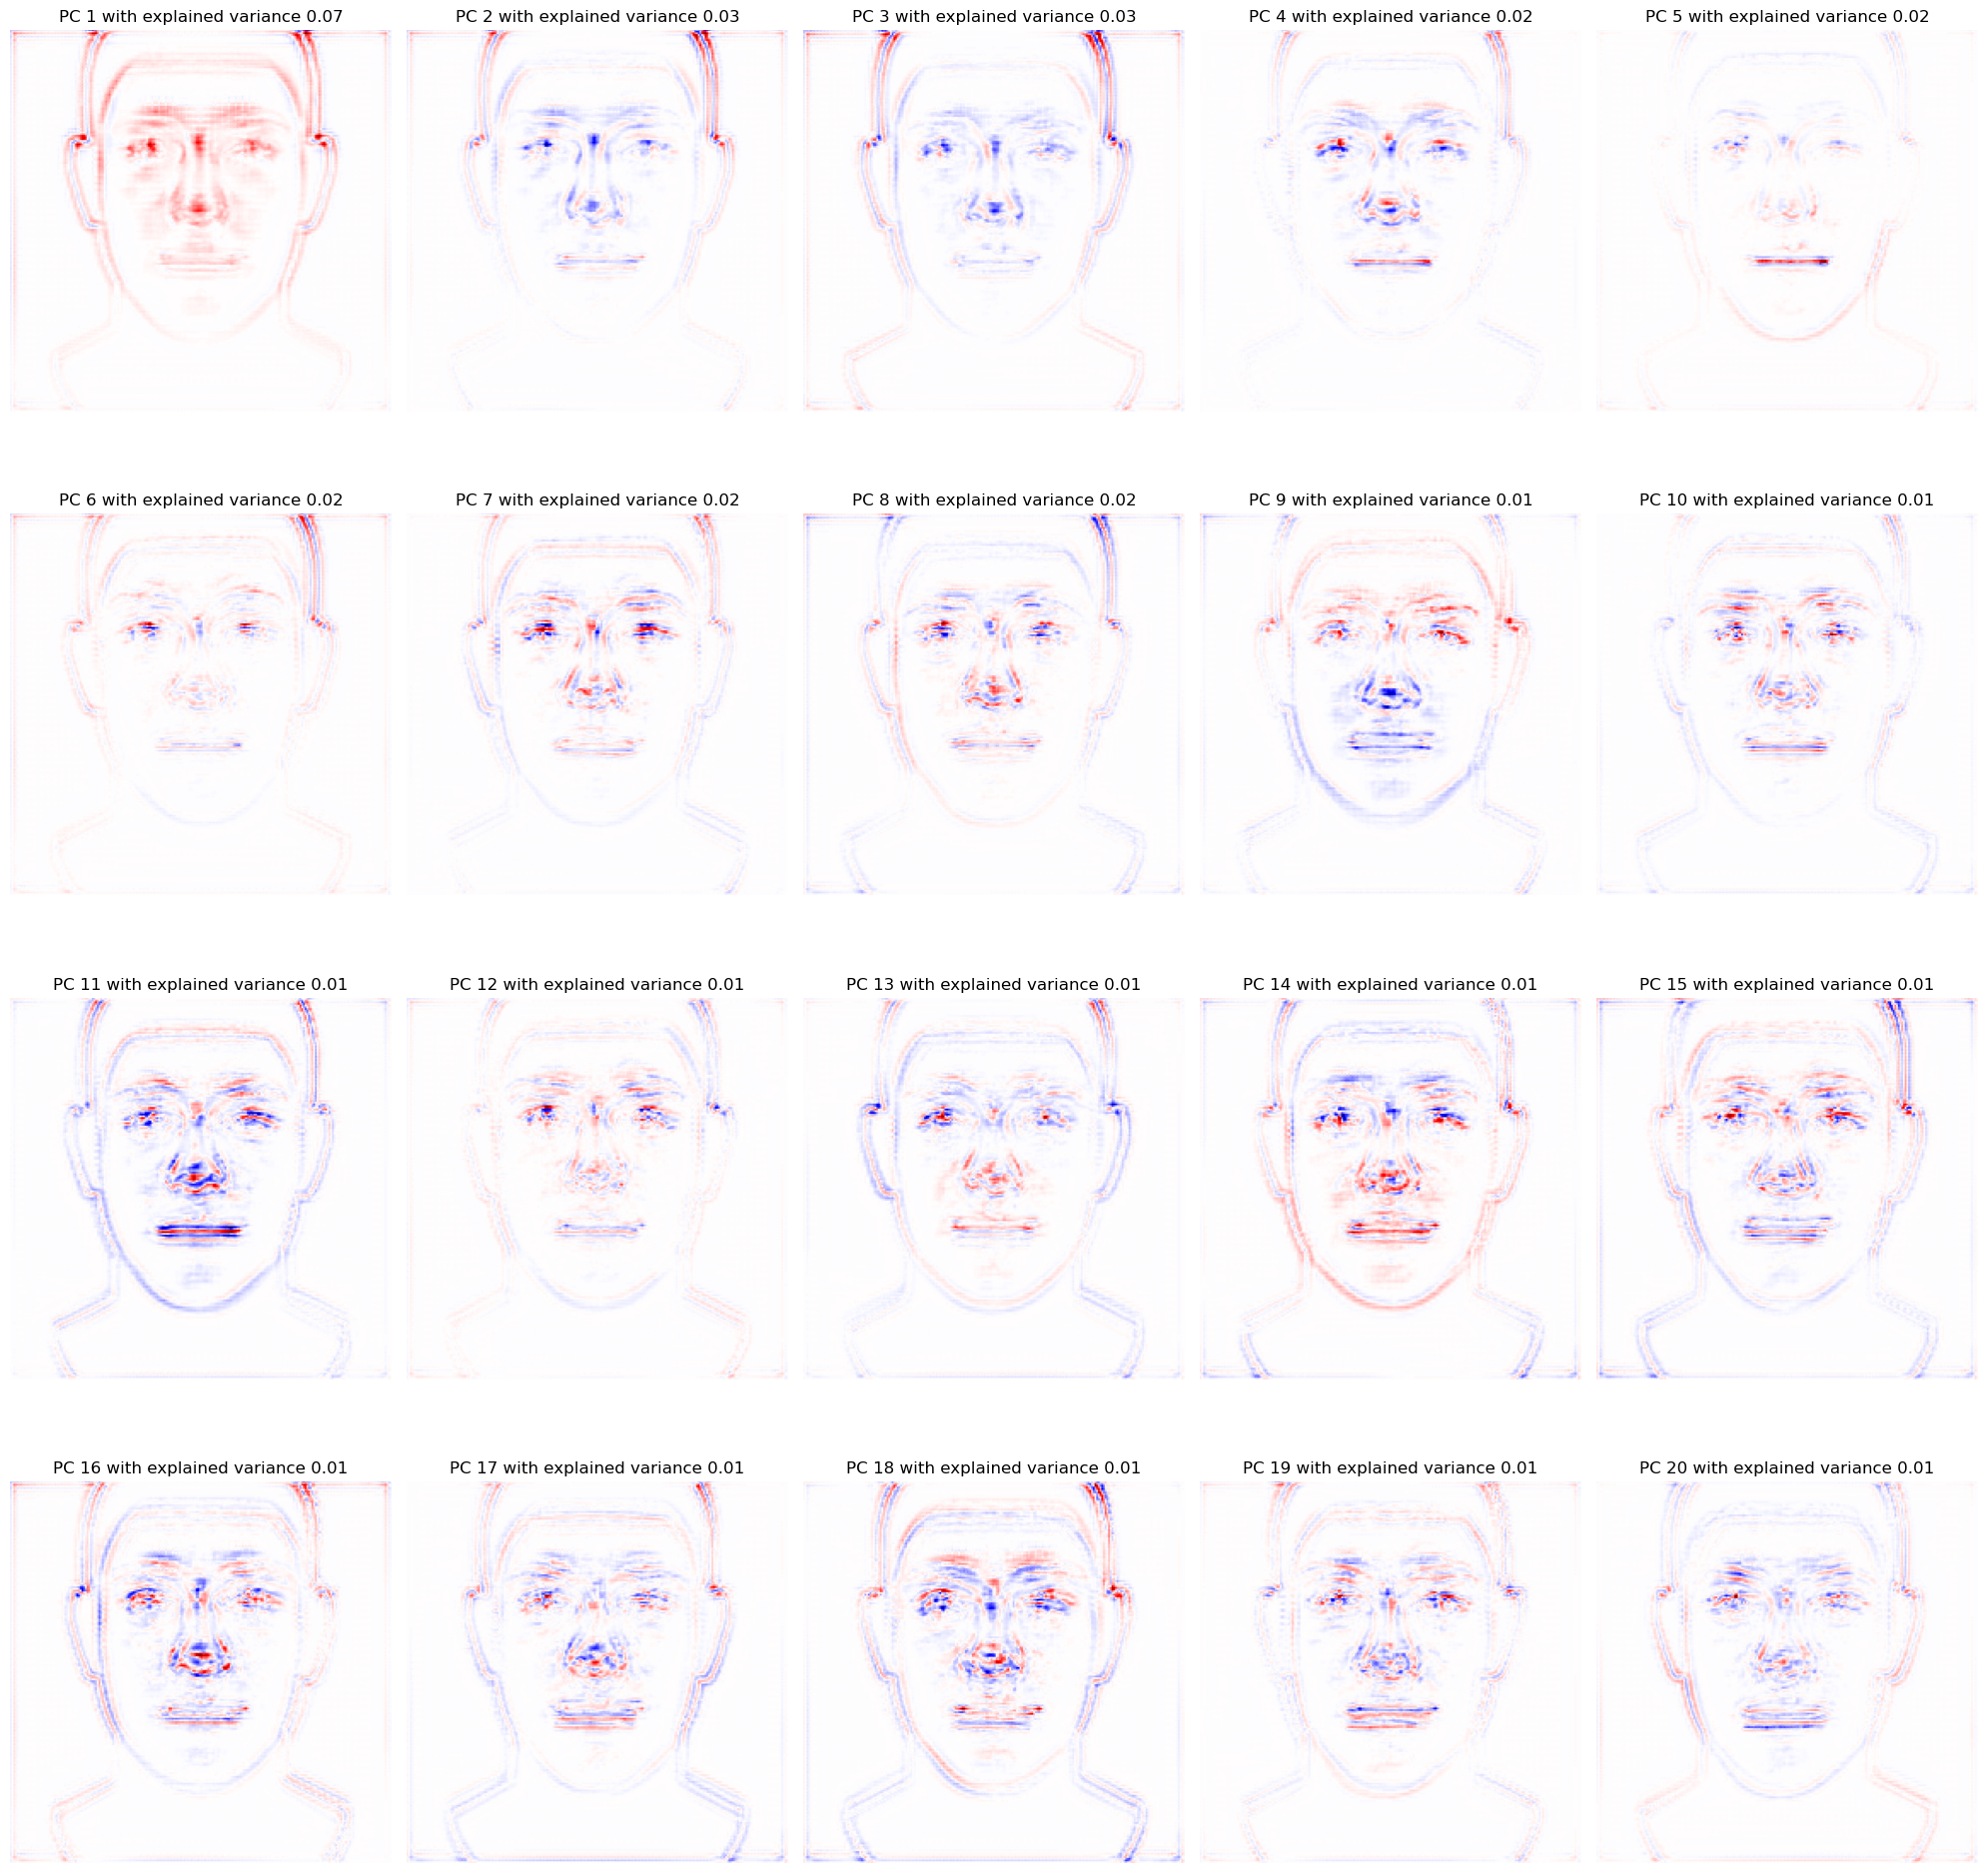

In [18]:
plt.figure(figsize=(20, 20)) 

# Plot the PCs
for i,pc in enumerate(pc_images):
    plt.subplot(int(np.ceil(len(pc_images)/5)), 5, i+1)  # 5 images per row
    amax = np.max(pc)
    vmin, vmax = -amax, amax
    plt.imshow(pc, cmap='seismic', vmin=vmin, vmax=vmax)
    plt.title(f"PC {i+1} with explained variance {ipca.explained_variance_ratio_[i]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()